In [ ]:
%load_ext autoreload
%autoreload 2

from test_repo_biometric import *
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [ ]:
# get the file names
train_files, test_files = train_test_all_ids('/data/home/shruti/voxceleb/vgg/leaders/')

In [ ]:
# first create a distribution of distance for VGG and FABNET using leaders and GG train data
# problem: Train files are very overlapping to each other and can skew the distriution
d_files = ['bo','br','bs','cb','dt','ew','hc','jb','kh', 'pb'] + ['GG_{0:02d}'.format(x+1) for x in range(28)]

distrib_VGG, bins_VGG = get_orig_distribution('/data/home/shruti/voxceleb/vgg/leaders/', 
                                    {f: train_files[f] for f in d_files})
distrib_VGG = np.cumsum(distrib_VGG)

distrib_Fabnet, bins_Fabnet = get_orig_distribution('/data/home/shruti/voxceleb/fabnet_metric/', 
                                      {f: train_files[f] for f in d_files})
distrib_Fabnet = np.cumsum(distrib_Fabnet)


In [3]:
# create a train repo with all the original people
def get_train_repo(params):
    
    out_repo = {}
    # leaders
    out_repo = build_repo(params['bsfldr'], 
                      {f: train_files[f] for f in ['bo','br','bs','cb','dt','ew','hc','jb','kh', 'pb',
                                                  'bo_imposter','bs_imposter','ew_imposter','dt_imposter',
                                                   'hc_imposter', 'jb_imposter']}, 
                      {'frames': params['frames'], 'step': params['steps'], 'pool_func': np.mean, 
                       'N': 5000, 'n1':0, 'n2':1}, 
                      in_dict=out_repo)
    # ff original
    out_repo = build_repo(params['bsfldr'], 
                  {'FF_{0:03d}'.format(f): train_files['FF_{0:03d}'.format(f)] for f in range(1000)}, 
                  {'frames': params['frames'], 'step': params['steps'], 'pool_func': np.mean, 
                   'N': 5000, 'n1':0, 'n2':0.5}, 
                  in_dict=out_repo)

    # Google 
    out_repo = build_repo(params['bsfldr'], 
                  {'GG_{0:02d}'.format(f+1): train_files['GG_{0:02d}'.format(f+1)] for f in range(28)}, 
                  {'frames': params['frames'], 'step': params['steps'], 'pool_func': np.mean, 
                   'N': 5000, 'n1':0, 'n2':1}, 
                  in_dict=out_repo)

    return out_repo



In [28]:

def get_result_df(vgg_repo, fabnet_repo, k=1):
    
    out_result_df = {}
    for r_or_f in ['real', 'fake']:

        r_or_f_res = {}
        test_keys = np.sort(list(test_files[r_or_f].keys()))
        
        for ids in test_keys:
            
            vgg_test = {}
            vgg_test = build_repo('/data/home/shruti/voxceleb/vgg/leaders/', 
                                     {ids: test_files[r_or_f][ids]}, 
                                     {'frames': 100, 'step': 5, 
                                      'pool_func': np.mean, 'N': 5000, 
                                      'n1':0.5 if 'FF_' in ids else 0, 'n2':1}, 
                                     in_dict=vgg_test)
            fabnet_test = {}
            fabnet_test = build_repo('/data/home/shruti/voxceleb/fabnet_metric/', 
                                     {ids: test_files[r_or_f][ids]}, 
                                     {'frames': 1, 'step': 1, 
                                      'pool_func': np.mean, 'N': 5000, 
                                      'n1':0.5 if 'FF_' in ids else 0, 'n2':1}, 
                                     in_dict=fabnet_test)
            
            
            cur_max, cur_pred_id = get_repo_dist(vgg_repo, vgg_test[ids], k=k)
            smpls = np.min([len(fabnet_test[ids]), len(vgg_test[ids])])
            cur_max = cur_max[:smpls].copy()
            cur_pred_id = cur_pred_id[:smpls].copy()
            
            r_or_f_res[ids] = pd.DataFrame(data=cur_max, columns=['VGG_dist'])
            r_or_f_res[ids]['predLabel'] = cur_pred_id
            r_or_f_res[ids]['actualLabel'] = ids
            r_or_f_res[ids]['RealFake'] = r_or_f
            
            fab_dist = np.zeros((smpls, ))
            for i in range(smpls):
                fab_dist[i], _ = get_repo_dist({cur_pred_id[i]: fabnet_repo[cur_pred_id[i]]}, 
                                            fabnet_test[ids][[i], :], k=k)
            
            r_or_f_res[ids]['Fabnet_dist'] = fab_dist

        out_result_df[r_or_f] = pd.concat([r_or_f_res[f] for f in test_keys], ignore_index=True, sort=False)

    return pd.concat([out_result_df[f] for f in ['real', 'fake']], ignore_index=True, sort=False)


In [30]:
def get_result_df_with_actualID(vgg_repo, fabnet_repo, k=1):
    
    out_result_df = {}
    for r_or_f in ['real', 'fake']:

        r_or_f_res = {}
        test_keys = np.sort(list(test_files[r_or_f].keys()))
        
        for ids in test_keys:
            
            vgg_test = {}
            vgg_test = build_repo('/data/home/shruti/voxceleb/vgg/leaders/', 
                                     {ids: test_files[r_or_f][ids]}, 
                                     {'frames': 100, 'step': 5, 
                                      'pool_func': np.mean, 'N': 5000, 
                                      'n1':0.5 if 'FF_' in ids else 0, 'n2':1}, 
                                     in_dict=vgg_test)
            fabnet_test = {}
            fabnet_test = build_repo('/data/home/shruti/voxceleb/fabnet_metric/', 
                                     {ids: test_files[r_or_f][ids]}, 
                                     {'frames': 1, 'step': 1, 
                                      'pool_func': np.mean, 'N': 5000, 
                                      'n1':0.5 if 'FF_' in ids else 0, 'n2':1}, 
                                     in_dict=fabnet_test)
            
            
            
            smpls = np.min([len(fabnet_test[ids]), len(vgg_test[ids])])
            
            vgg_max, _ = get_repo_dist({ids: vgg_repo[ids]}, vgg_test[ids], k=k)
            fab_max, _ = get_repo_dist({ids: fabnet_repo[ids]}, fabnet_test[ids], k=k)
            
            r_or_f_res[ids] = pd.DataFrame(data=vgg_max[:smpls], columns=['VGG_dist'])
            r_or_f_res[ids]['actualLabel'] = ids
            r_or_f_res[ids]['RealFake'] = r_or_f
            r_or_f_res[ids]['Fabnet_dist'] = fab_max[:smpls]

        out_result_df[r_or_f] = pd.concat([r_or_f_res[f] for f in test_keys], ignore_index=True, sort=False)

    return pd.concat([out_result_df[f] for f in ['real', 'fake']], ignore_index=True, sort=False)



# VGG + Fabnet Metric

In [6]:

# repo with leaders
vgg_repo = get_train_repo({'istrain':True, 'bsfldr':'/data/home/shruti/voxceleb/vgg/leaders/', 
                                'frames':100, 'steps':5})
fab_repo = get_train_repo({'istrain':True, 'bsfldr':'/data/home/shruti/voxceleb/fabnet_metric/', 
                                'frames':1, 'steps':1})


In [15]:

result_df = get_result_df(vgg_repo, fab_repo)


# Get results with actual ID

In [34]:

result_df_with_actual_ID = get_result_df_with_actualID(vgg_repo, fab_repo)


# VGG + Fabnet Metric K-Mean

In [38]:

result_df_k10 = get_result_df(vgg_repo, fab_repo, k=10)


# results

In [31]:
# with only leaders in repository
# if we had leaders in the repo and we get the face-swap of leaders dist
# how we do on Leader Faceswap
def get_auc(in_result_df, in_dist_name, real_nm, fake_nm):
    
    real_dist = in_result_df.loc[np.logical_and(in_result_df['actualLabel'].isin(real_nm), 
                                                in_result_df['RealFake']=='real'), in_dist_name]
    
    fake_dist = in_result_df.loc[np.logical_and(in_result_df['actualLabel'].isin(fake_nm), 
                                                in_result_df['RealFake']=='fake'), in_dist_name]
    
    fpr, tpr, thresholds = roc_curve(np.concatenate((np.ones((len(real_dist), )), 
                                                    np.zeros((len(fake_dist), )) )), 
                                     np.concatenate((real_dist, 
                                                     fake_dist)))
    return auc(fpr, tpr)
    
def plot_dist(in_result_df, in_dist_name, real_nm, fake_nm, ax, title):
    
    sns.distplot(np.log(in_result_df.loc[np.logical_and(in_result_df['actualLabel'].isin(real_nm), 
                                                in_result_df['RealFake']=='real'), in_dist_name]), 
                 bins=np.log(np.linspace(0.1, 2, 30)), label='real', ax=ax)
    sns.distplot(np.log(in_result_df.loc[np.logical_and(in_result_df['actualLabel'].isin(fake_nm), 
                                                in_result_df['RealFake']=='fake'), in_dist_name]), 
                 bins=np.log(np.linspace(0.1, 2, 30)), label='fake', ax=ax)
    ax.set_title(title)
    ax.set_xlim([np.log(0.1), np.log(1)])
    ax.legend()

### AUC results



#### K = 1

In [20]:
print('Repo Leaders + FF original + Imposters + Google')
print('\t VGG')

print('\t \t leaders {0:0.4f}'.format(get_auc(result_df, 'VGG_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df, 'VGG_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df, 'VGG_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))


print('\t Fabnet Metric')
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df, 'Fabnet_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df, 'Fabnet_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df, 'Fabnet_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))


print('\t VGG + Fabnet')
result_df['VGG_Fabnet_dist'] = np.array(result_df['VGG_dist']) + np.array(result_df['Fabnet_dist'])
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df, 'VGG_Fabnet_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df, 'VGG_Fabnet_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df, 'VGG_Fabnet_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))


Repo Leaders + FF original + Imposters + Google
	 VGG
	 	 leaders 0.8792
	 	 FaceForensics 0.9976
	 	 Google 0.9838
	 Fabnet Metric
	 	 leaders 0.8879
	 	 FaceForensics 0.9957
	 	 Google 0.9352
	 VGG + Fabnet
	 	 leaders 0.9095
	 	 FaceForensics 0.9973
	 	 Google 0.9719


In [37]:
print('Repo Leaders + FF original + Imposters + Google')
print('\t VGG')

print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'VGG_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'VGG_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'VGG_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))


print('\t Fabnet Metric')
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'Fabnet_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'Fabnet_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'Fabnet_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))


print('\t VGG + Fabnet')
result_df_with_actual_ID['VGG_Fabnet_dist'] = np.array(result_df_with_actual_ID['VGG_dist']) + np.array(result_df_with_actual_ID['Fabnet_dist'])
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'VGG_Fabnet_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'VGG_Fabnet_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df_with_actual_ID, 'VGG_Fabnet_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))



Repo Leaders + FF original + Imposters + Google
	 VGG
	 	 leaders 0.8862
	 	 FaceForensics 0.9984
	 	 Google 0.9896
	 Fabnet Metric
	 	 leaders 0.9384
	 	 FaceForensics 0.9985
	 	 Google 0.9776
	 VGG + Fabnet
	 	 leaders 0.9525
	 	 FaceForensics 0.9988
	 	 Google 0.9942


#### K = 10

In [40]:
print('Repo Leaders + FF original + Imposters + Google')

print('\t VGG')
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_k10, 'VGG_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df_k10, 'VGG_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df_k10, 'VGG_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))


print('\t Fabnet Metric')
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_k10, 'Fabnet_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df_k10, 'Fabnet_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df_k10, 'Fabnet_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))


print('\t VGG + Fabnet')
result_df_k10['VGG_Fabnet_dist'] = np.array(result_df_k10['VGG_dist']) + np.array(result_df_k10['Fabnet_dist'])
print('\t \t leaders {0:0.4f}'.format(get_auc(result_df_k10, 'VGG_Fabnet_dist', 
                                              ['bo','bs','dt','ew','hc','jb'], 
                                              ['bo','bs','dt','ew','hc','jb'])))
print('\t \t FaceForensics {0:0.4f}'.format(get_auc(result_df_k10, 'VGG_Fabnet_dist', 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)], 
                                              ['FF_{0:03d}'.format(f) for f in range(1000)])))
print('\t \t Google {0:0.4f}'.format(get_auc(result_df_k10, 'VGG_Fabnet_dist', 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)], 
                                              ['GG_{0:02d}'.format(f+1) for f in range(28)])))

Repo Leaders + FF original + Imposters + Google
	 VGG
	 	 leaders 0.8801
	 	 FaceForensics 0.9974
	 	 Google 0.9831
	 Fabnet Metric
	 	 leaders 0.8793
	 	 FaceForensics 0.9951
	 	 Google 0.9358
	 VGG + Fabnet
	 	 leaders 0.9032
	 	 FaceForensics 0.9970
	 	 Google 0.9718


# Distributions

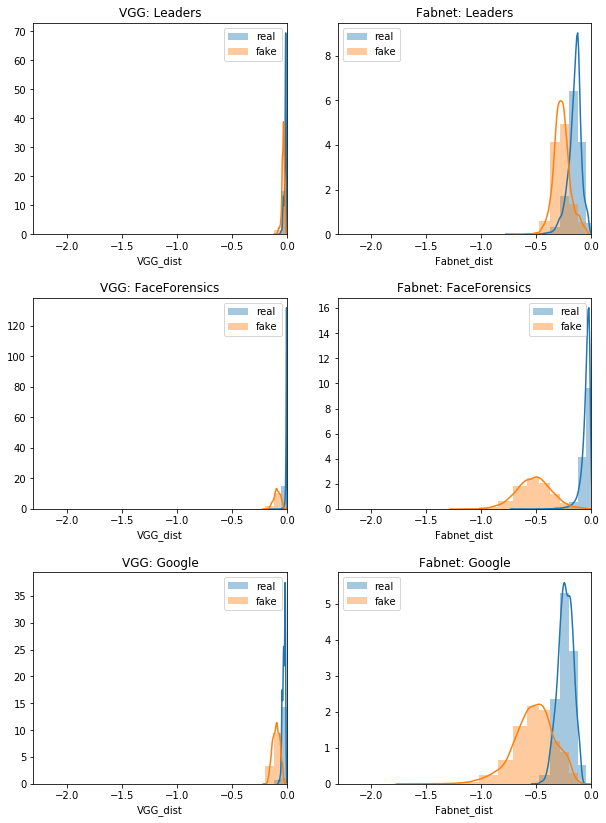

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,14))

plot_dist(result_df, 'VGG_dist', ['bo','bs','dt','ew','hc','jb'], 
          ['bo','bs','dt','ew','hc','jb'], 
          ax[0, 0], 'VGG: Leaders')
plot_dist(result_df, 'VGG_dist', ['FF_{0:03d}'.format(f) for f in range(1000)], 
          ['FF_{0:03d}'.format(f) for f in range(1000)], ax[1, 0], 
          'VGG: FaceForensics')
plot_dist(result_df, 'VGG_dist', ['GG_{0:02d}'.format(f+1) for f in range(28)], 
          ['GG_{0:02d}'.format(f+1) for f in range(28)], ax[2, 0], 
          'VGG: Google')

plot_dist(result_df, 'Fabnet_dist', ['bo','bs','dt','ew','hc','jb'], 
          ['bo','bs','dt','ew','hc','jb'], 
          ax[0, 1], 'Fabnet: Leaders')
plot_dist(result_df, 'Fabnet_dist', ['FF_{0:03d}'.format(f) for f in range(1000)], 
          ['FF_{0:03d}'.format(f) for f in range(1000)], ax[1, 1], 
          'Fabnet: FaceForensics')
plot_dist(result_df, 'Fabnet_dist', ['GG_{0:02d}'.format(f+1) for f in range(28)], 
          ['GG_{0:02d}'.format(f+1) for f in range(28)], ax[2, 1], 
          'Fabnet: Google')
plt.subplots_adjust(hspace=0.3)

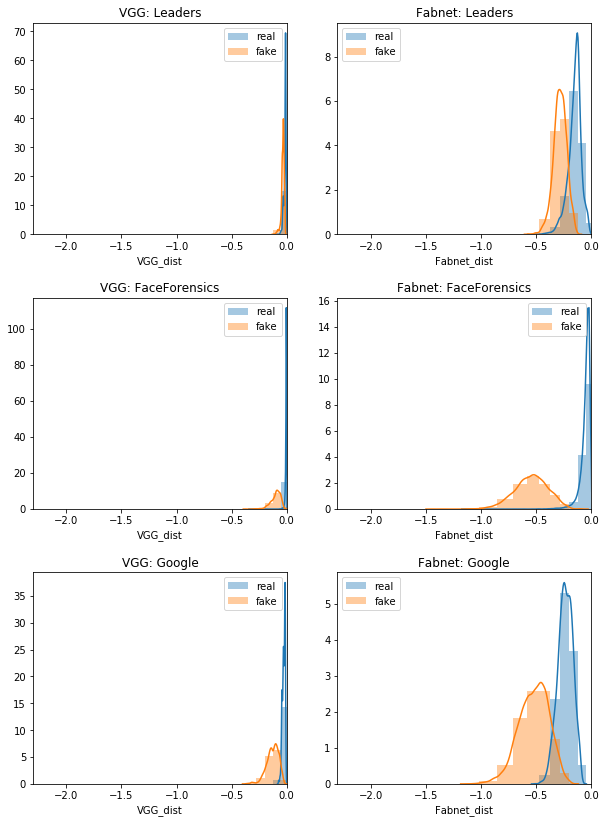

In [35]:

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,14))

plot_dist(result_df_with_actual_ID, 'VGG_dist', ['bo','bs','dt','ew','hc','jb'], 
          ['bo','bs','dt','ew','hc','jb'], 
          ax[0, 0], 'VGG: Leaders')
plot_dist(result_df_with_actual_ID, 'VGG_dist', ['FF_{0:03d}'.format(f) for f in range(1000)], 
          ['FF_{0:03d}'.format(f) for f in range(1000)], ax[1, 0], 
          'VGG: FaceForensics')
plot_dist(result_df_with_actual_ID, 'VGG_dist', ['GG_{0:02d}'.format(f+1) for f in range(28)], 
          ['GG_{0:02d}'.format(f+1) for f in range(28)], ax[2, 0], 
          'VGG: Google')

plot_dist(result_df_with_actual_ID, 'Fabnet_dist', ['bo','bs','dt','ew','hc','jb'], 
          ['bo','bs','dt','ew','hc','jb'], 
          ax[0, 1], 'Fabnet: Leaders')
plot_dist(result_df_with_actual_ID, 'Fabnet_dist', ['FF_{0:03d}'.format(f) for f in range(1000)], 
          ['FF_{0:03d}'.format(f) for f in range(1000)], ax[1, 1], 
          'Fabnet: FaceForensics')
plot_dist(result_df_with_actual_ID, 'Fabnet_dist', ['GG_{0:02d}'.format(f+1) for f in range(28)], 
          ['GG_{0:02d}'.format(f+1) for f in range(28)], ax[2, 1], 
          'Fabnet: Google')
plt.subplots_adjust(hspace=0.3)
